# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

# Import raw data

In [2]:
#File containing temperature values
raw_T_data = np.loadtxt('/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/Data/bt-4500k/training_data_T.csv', delimiter=',')
#File containing pressure values
raw_P_data = np.loadtxt('/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/Data/bt-4500k/training_data_P.csv', delimiter=',')
#Path to store model
model_save_path = '/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/Data/Model_Storage/'

#Last 51 columns are the temperature/pressure values, 
#First 5 are the input values (H2 pressure in bar, CO2 pressure in bar, LoD in hours, Obliquity in deg, H2+Co2 pressure) but we remove the last one since it's not adding info.
raw_inputs = raw_T_data[:, :4]
raw_outputs_T = raw_T_data[:, 5:]
raw_outputs_P = raw_P_data[:, 5:]

#Storing useful quantitites
N = raw_inputs.shape[0] #Number of data points
D = raw_inputs.shape[1] #Number of features
O = raw_outputs_T.shape[1] #Number of outputs


# Fitting the training data with a basic deep neural network

## 0th step : Shrink down data so we can work with it locally

In [3]:
#Number of samples to shrink our dataset to 
sample_size = 10000

filter = np.random.choice(np.arange(N), size=sample_size, replace=False)

raw_inputs = torch.tensor(raw_inputs[filter, :], dtype=torch.float32)
raw_outputs_T = torch.tensor(raw_outputs_T[filter, :], dtype=torch.float32)
raw_outputs_P = torch.tensor(raw_outputs_P[filter, :], dtype=torch.float32)

N = sample_size

## First step : Define a training, validation, and testing set

In [4]:
#Defining partition of data used for 1. training 2. validation and 3. testing
data_partitions = [0.7, 0.1, 0.2]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

#Splitting the data 
## Setting noise seec
generator = torch.Generator().manual_seed(partition_seed)
## Retrieving indices of data partitions
train_idx, valid_idx, test_idx = torch.utils.data.random_split(range(N), data_partitions, generator=generator)
## Generate the data partitions
### Training
train_inputs = raw_inputs[train_idx]
train_outputs_T = raw_outputs_T[train_idx]
train_outputs_P = raw_outputs_P[train_idx]
### Validation
valid_inputs = raw_inputs[valid_idx]
valid_outputs_T = raw_outputs_T[valid_idx]
valid_outputs_P = raw_outputs_P[valid_idx]
### Testing
test_inputs = raw_inputs[test_idx]
test_outputs_T = raw_outputs_T[test_idx]
test_outputs_P = raw_outputs_P[test_idx]

## Second step : Define the neural network

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            #Input layer
            ## Pre-activation
            nn.Linear(in_features = 4, out_features=100),
            ## Activation
            nn.ReLU(),
            #Hidden layer n.1
            nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU(),
            #Hidden layer n.2
            nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU(),
            #Hidden layer n.3
            nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU(),
            #Hidden layer n.4
            nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU(),
            #Hidden layer n.5
            nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU(),
            #Output layer
            nn.Linear(in_features = 100, out_features = 51),
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

## Third step : Define device for training

In [6]:
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cpu"
num_threads = 6
torch.set_num_threads(num_threads)
print(f"Using {device} device with {num_threads} threads")

Using cpu device with 6 threads


In [7]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=51, bias=True)
  )
)


## Fourth step : Define optimization functions

In [8]:
# --- Loss and optimizer ---
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


# --- Training loop ---
def train_loop(inputs, targets, model, loss_fn, optimizer):
    model.train()
    pred = model(inputs)
    loss = loss_fn(pred, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def eval_loop(inputs, targets, model, loss_fn):
    model.eval()
    with torch.no_grad():
        pred = model(inputs)
        loss = loss_fn(pred, targets)
    return loss.item()

## Fifth step : Run optimization

In [9]:
#Define number of epochs 
n_epochs = 30000

#Define storage for losses
train_losses = np.zeros(n_epochs, dtype=float)
val_losses = np.zeros(n_epochs, dtype=float)

In [10]:
# --- Training ---
for epoch in range(n_epochs):
    train_losses[epoch] = train_loop(train_inputs, train_outputs_T, model, loss_fn, optimizer)
    val_losses[epoch] = eval_loop(valid_inputs, valid_outputs_T, model, loss_fn)

    print(f"Epoch {epoch:03d}: train_loss={train_losses[epoch]:.5f}, val_loss={val_losses[epoch]:.5f}")

#Save model 
torch.save(model.state_dict(), model_save_path + f'NN_{n_epochs}epochs.pth')

Epoch 000: train_loss=46313.10547, val_loss=46319.77734
Epoch 001: train_loss=46312.81250, val_loss=46319.48438
Epoch 002: train_loss=46312.51953, val_loss=46319.19531
Epoch 003: train_loss=46312.23438, val_loss=46318.90234
Epoch 004: train_loss=46311.94141, val_loss=46318.61719
Epoch 005: train_loss=46311.66016, val_loss=46318.33203
Epoch 006: train_loss=46311.37500, val_loss=46318.03906
Epoch 007: train_loss=46311.08984, val_loss=46317.75781
Epoch 008: train_loss=46310.80859, val_loss=46317.47656
Epoch 009: train_loss=46310.52734, val_loss=46317.19531
Epoch 010: train_loss=46310.25391, val_loss=46316.92188
Epoch 011: train_loss=46309.98438, val_loss=46316.64453
Epoch 012: train_loss=46309.70312, val_loss=46316.37891
Epoch 013: train_loss=46309.43750, val_loss=46316.10156
Epoch 014: train_loss=46309.16797, val_loss=46315.83984
Epoch 015: train_loss=46308.91016, val_loss=46315.58203
Epoch 016: train_loss=46308.64844, val_loss=46315.31250
Epoch 017: train_loss=46308.39062, val_loss=4631

In [11]:
# --- Testing ---
test_loss = eval_loop(test_inputs, test_outputs_T, model, loss_fn)
print(f"\nFinal test loss: {test_loss:.5f}")


Final test loss: 126.51097


## Sixth step : Diagnostic plots

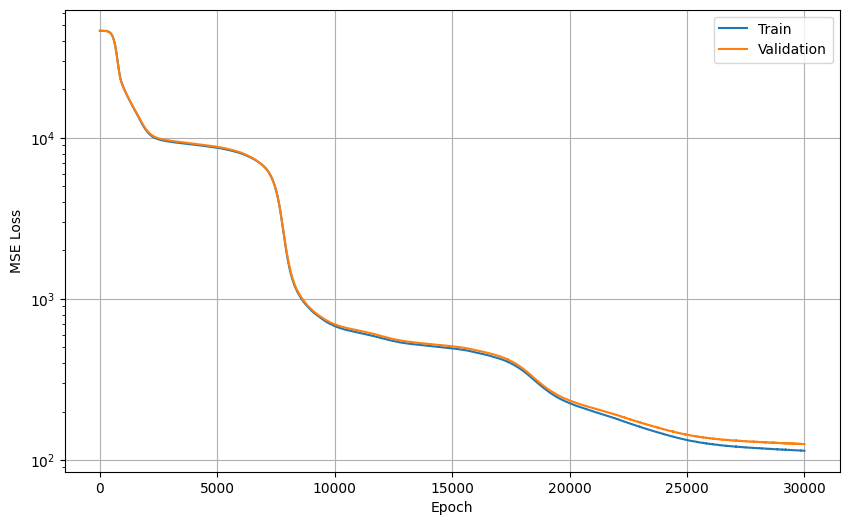

In [12]:
# Loss curves
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_epochs), train_losses, label="Train")
plt.plot(np.arange(n_epochs), val_losses, label="Validation")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

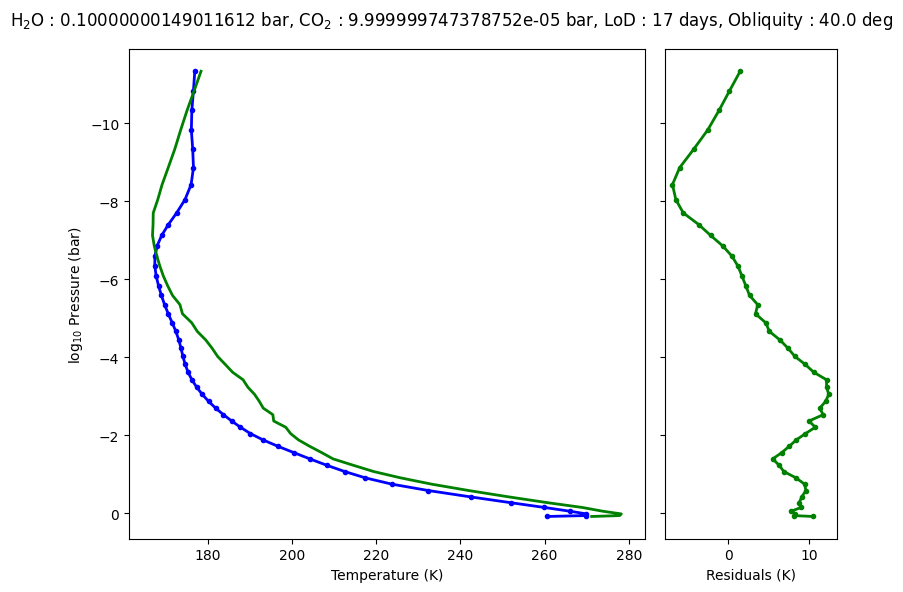

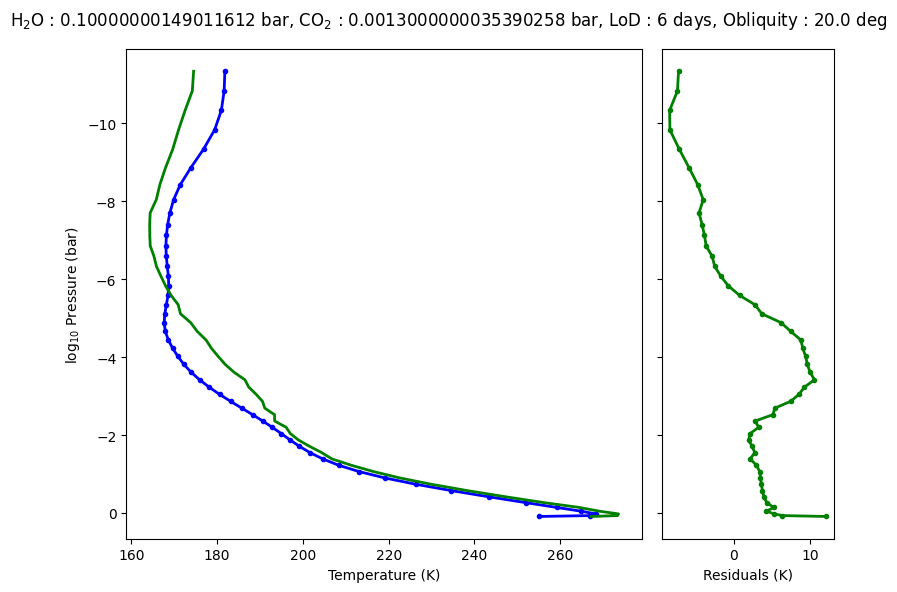

In [15]:
#Comparing predicted T-P profiles vs true T-P profiles with residuals
substep = 1000

#Converting tensors to numpy arrays if this isn't already done
if (type(test_outputs_T) != np.ndarray):
    test_outputs_T = test_outputs_T.numpy()
    test_outputs_P = test_outputs_P.numpy()

for test_idx, (test_input, test_output_T, test_output_P) in enumerate(zip(test_inputs, test_outputs_T, test_outputs_P)):

    #Retrieve prediction
    pred_output_T = model(test_input).detach().numpy()

    #Convert to numpy
    test_input = test_input.numpy()

    #Plotting
    if (test_idx % substep == 0):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 6], sharey=True, gridspec_kw = {'width_ratios':[3, 1]})
        ax1.plot(test_output_T, np.log(test_output_P/1000), '.', linestyle='-', color='blue', linewidth=2)
        ax1.plot(pred_output_T, np.log(test_output_P/1000), color='green', linewidth=2)
        ax1.invert_yaxis()
        ax1.set_ylabel(r'log$_{10}$ Pressure (bar)')
        ax1.set_xlabel('Temperature (K)')
        ax2.plot(pred_output_T - test_output_T, np.log(test_output_P/1000), '.', linestyle='-', color='green', linewidth=2)
        ax2.set_xlabel('Residuals (K)')
        plt.suptitle(rf'H$_2$O : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.tight_layout()
        plt.show()
    

(2000, 51)


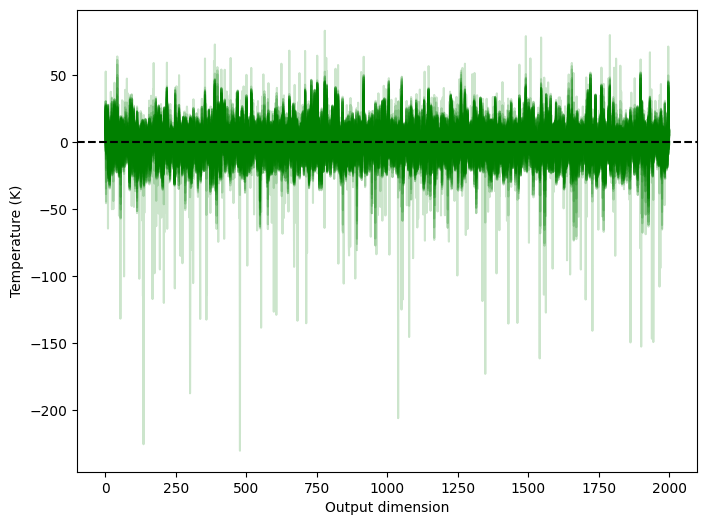

Median: 0.022 K, Standard deviation: 11.248 K


In [29]:
#Plotting all residuals 

#Storage
residuals = np.zeros(test_outputs_T.shape,  dtype=object)
print(residuals.shape)

#Converting tensors to numpy arrays if this isn't already done
if (type(test_outputs_T) != np.ndarray):
    test_outputs_T = test_outputs_T.numpy()

for test_idx, (test_input, test_output_T) in enumerate(zip(test_inputs, test_outputs_T)):

    #Retrieve prediction
    residuals[test_idx] = model(test_input).detach().numpy() - test_output_T


fig, ax = plt.subplots(figsize=[8, 6])
ax.plot(residuals, color='green', alpha=0.2)
ax.axhline(0, color='black', linestyle='dashed')
plt.xlabel('Output dimension')
plt.ylabel('Temperature (K)')
plt.show()
print(f'Median: {np.median(residuals):.3f} K, Standard deviation: {np.std(residuals):.3f} K')